### Load required libraries

In [1]:
## basc libraries
from __future__ import division
import os
from glob import glob

import urllib, cStringIO

## pymongo
import pymongo as pm

## plotting libraries
import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

## basic
import numpy as np
import pandas as pd
import json
import re

## for images
from PIL import Image
import base64

## scipy stats
import scipy.stats as stats
from scipy.spatial import distance
from scipy.stats import norm
import scipy.stats as stats

## sklearn
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import linear_model, datasets, neighbors
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

## under/over sampling libraries
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

## custom functions
import embedding as emb
reload(emb)
from embedding import *

### Get sketch paths

In [2]:
# # Retrieve sketch paths -- pngs rendered out in another step
# def list_files(path, ext='png'):
#     result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.%s' % ext))]
#     return result

# # extract metadata
# path_to_sketches = 'srcd-features/museumstation_sketches'
# sketch_paths = sorted(list_files(path_to_sketches))

# ## number of sketch paths 
# print 'Number of sketch paths = {} before filtering'.format(len(sketch_paths))
# png_sketch_count = len(sketch_paths)

## Extract features

**Dec 28 2017 (updated Jan 14 2018):** <br>
 - From command line, extract features using `extract_features.py`. The default arguments are for the kid's drawings. <br>

## Define local custom functions

In [3]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def normalize_RDM(MAT):
    X = MAT - MAT.mean(0).mean(0)
    X = X / np.maximum(MAT.std(0).std(0), 1e-5)
    return X

def flatten(x):
    return [item for sublist in x for item in sublist]

def get_class_means(X, labels):    
    # load in and normalizes features first
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def get_class_means_not_normalized(X, labels):    
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu
    
def load_features(cohort, layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']    
    F = np.load('srcd-features/museumstation_features/FEATURES_{}_{}_Spatial_True.npy'.format(layers[layer_num],cohort))
    M = pd.read_csv('srcd-features/museumstation_features/METADATA_{}.csv'.format(cohort)) 
    M = M[['label','age','session']]
    return F, M

def remove_practice_trials(KF,KM):
    '''
    remove "circle" and "triangle" trials from dataset
    '''
    practice_objects = ['circle','triangle']
    _KF = KF[~KM['label'].isin(practice_objects),:]
    _KM = KM[~KM['label'].isin(practice_objects)]
    return _KF, _KM

def restrict_sesion(KF,KM,session_label):
    '''
    only look at drawings from certain session
    '''
    _KF = KF[KM['session'].str.contains(session_label),:]
    _KM = KM[KM['session'].str.contains(session_label)]
    return _KF, _KM

def plot_rdm_by_class(Features,X,layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']        
    sns.set_style('white')
    fig = plt.figure(figsize=(6,6))
    labels = X.label.values
    means = get_class_means(Features, labels)
    CORRMAT = np.corrcoef(means)
    plt.matshow(CORRMAT)
    plt.colorbar()
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig('./plots/RDM_by_view_{}.pdf'.format(layers[layer_num]))


### Load features and downsample to same dataset used in classifications / r notebook for submission

In [75]:
## CHOOSE LAYER IND FOR PLOTTING RDMS ETC
layer_ind = 6
session_label = "run_v3"

## load in kid features
KF, KM = load_features('kid',layer_ind)

## do same random under sampling we did for classification (set random state to same value)
# rus = RandomUnderSampler(random_state=0)
# KF_downsampled, class_labels_downsampled = rus.fit_resample(KF, KM['label'].values)
# new_samples_ind = rus.sample_indices_
# KM_downsampled = KM.loc[new_samples_ind]

# ## reassign variable names
# KM = KM_downsampled
# KF = KF_downsampled

# ## restrict to classifcation outputs from cdm_run_v3 to match with mongodb meta; 
# ## we are actually missing 10 drawings from classification 
# ##(likely lost server conncetion) so have 10 more here...ugh
# KF, KM = restrict_sesion(KF,KM,session_label)
# KM = KM.reset_index(drop=True)

## print some variables
print 'Number of unique kids who contributed drawings = {}'.format(np.size(np.unique(KM['session'].values)))
print 'Number of features for {} images in layer {} = {}'.format(np.shape(KF)[0], layer_ind, np.shape(KF)[1])
feature_sketch_count = np.shape(KF)[0]

# excluded_drawing_number = png_sketch_count - feature_sketch_count
# print 'Number of excluded drawings = {}'.format(excluded_drawing_number)

Number of unique kids who contributed drawings = 1447
Number of features for 7326 images in layer 6 = 4096


### Get out labels and sorting indexes for the classes in this dataset

In [76]:
_labels = np.unique(KM.label.values)
ordered_objs = ['an airplane', 'a bike', 'a car', 'a boat', 'a chair', 'a couch', 'a house', 'a cup', 'a bowl', 'a phone', 'a person', 'a bird', 'a dog', 'a fish', 'a rabbit', 'a tree']
ordered_objs = np.asarray(ordered_objs) ## will be used repetitively throughout
sort_inds = [np.where(_labels==ordered_objs[i])[0][0] for i in np.arange(len(ordered_objs))]

## save out for multiple uses
age_list = (2,3,4,5,6,7,8,9,10)

### How many drawings do we have in each age group?

In [77]:
for age in range(2,11):
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    print 'We have {} {}-year olds who contributed {} drawings'.format(np.shape(np.unique(KM_subset['session']))[0],age, np.shape(KM_subset)[0])

We have 207 2-year olds who contributed 729 drawings
We have 271 3-year olds who contributed 1266 drawings
We have 218 4-year olds who contributed 1049 drawings
We have 196 5-year olds who contributed 1115 drawings
We have 161 6-year olds who contributed 933 drawings
We have 113 7-year olds who contributed 649 drawings
We have 108 8-year olds who contributed 582 drawings
We have 68 9-year olds who contributed 409 drawings
We have 105 10-year olds who contributed 594 drawings


# Examine changes in variability

### Measure overall feature activation, image variability in feature space, and distances between category centers

In [78]:
def get_class_means_bl(F, M,ordered_objs):  # just adapted to take in features and metadata directly; doesn't normalize  
    X = F;
    labels = M.label.values
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    for vi, v in enumerate(ordered_objs):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

class_distance_by_age = np.zeros([9,120]) # save out all ages x pairwise category distances
feature_activation_by_age = np.zeros([9,4096]) # save out all ages x features

# image variability -- diff numbers of images per age group, just save out avg/std
avg_image_variability_by_age = np.zeros(9)
std_image_variability_by_age = np.zeros(9)
overall_dist = np.zeros([9,16])
overall_dist_sq = np.zeros([9,16])

age_list = (2,3,4,5,6,7,8,9,10)
for i,age in enumerate(age_list):
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    
    # how much are features activated overall, regardless of category
    feature_activation_by_age[i,] = np.mean(KF_subset, axis=0) ## by features
    
    # how much do images vary (on average) in their features by each age
    avg_image_variability_by_age[i] = np.mean(np.std(KF_subset,axis = 1))
    std_image_variability_by_age[i] = np.std(np.std(KF_subset,axis = 1))
    
    # get class means, compute distance, take average (function only gives upper triangle)
    class_means = get_class_means_bl(KF_subset,KM_subset, ordered_objs)
    age_distances = distance.pdist(class_means,'euclidean')
    grand_mean = np.mean(class_means,0)
    for c,l in enumerate(ordered_objs):
        overall_dist[i,c]=distance.cosine(grand_mean,class_means[c,])
        overall_dist_sq[i,c]=overall_dist[i,c]**2
#     class_distance_by_age[i,] = age_distances


### Category centers become farther away from eachother with age (overall expansion)

In [79]:
np.mean(overall_dist_sq,1)

array([ 0.3346442 ,  0.38176938,  0.67320416,  0.75259487,  0.76255781,
        0.79296682,  0.69160386,  0.68194964,  0.62292276])

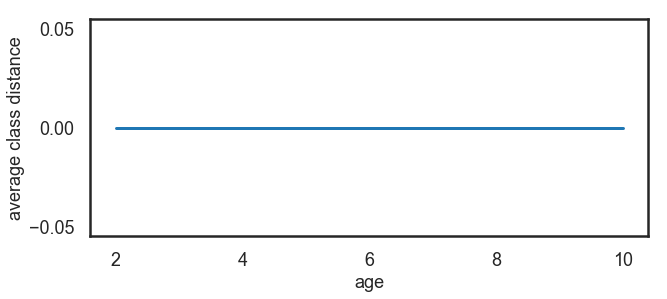

In [80]:

fig = plt.figure(figsize=(10,4))
# plt.plot(age_listmaverage_class_distance_by_age)
plt.errorbar(age_list,np.mean(class_distance_by_age, axis=1), np.std(class_distance_by_age, axis=1))
plt.ylabel('average class distance',fontsize = 18)
plt.xlabel('age', fontsize = 18)
plt.xticks(fontsize = 18); 
plt.yticks(fontsize = 18); 

plt.savefig('./plots/AvgCategoryDistbyAge.png', bbox_inches="tight")


### Average feature activation by age - lots of variability (errorbars = SD)

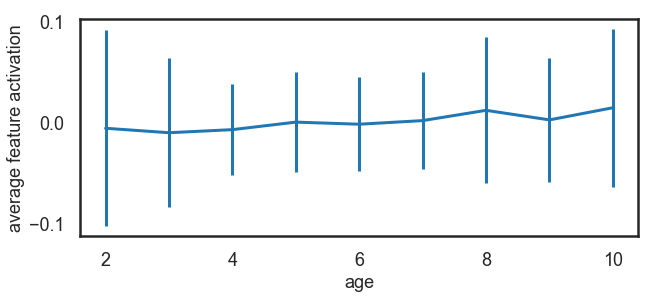

In [13]:
fig = plt.figure(figsize=(10,4))
plt.errorbar(age_list,np.mean(feature_activation_by_age,1),yerr = np.std(feature_activation_by_age,1))
plt.ylabel('average feature activation',fontsize = 18)
plt.xlabel('age', fontsize = 18)
plt.xticks(fontsize = 18); 
plt.yticks(fontsize = 18); 

plt.savefig('./plots/FeatureActivationbyAge.png', bbox_inches="tight")

### Average image variability by age - also lots of variation (errorbars = SD)

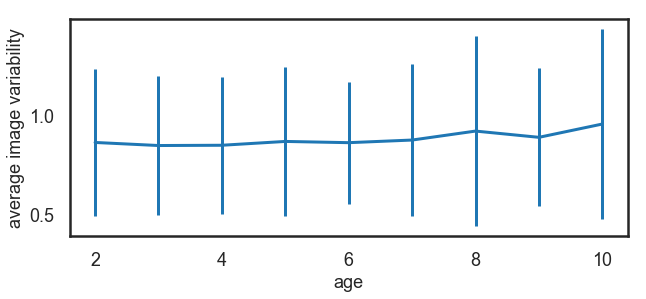

In [14]:
fig = plt.figure(figsize=(10,4))
plt.errorbar(age_list,avg_image_variability_by_age,yerr = std_image_variability_by_age)
plt.ylabel('average image variability',fontsize = 18)
plt.xlabel('age', fontsize = 18)
plt.xticks(fontsize = 18); 
plt.yticks(fontsize = 18); 

plt.savefig('./plots/ImageVariabilitybyAge.png', bbox_inches="tight")

## How does category dispersion change with age?

In [81]:

class_distances=np.zeros([9,16])
class_distance_variation=np.zeros([9,16])

def get_cosine_distance_to_center(F,M,this_label):    
    class_features = F[M.label.values==this_label]
    class_mean = class_features.mean(0); # mean ovver rows, i.e. images
    num_images = np.shape(class_features)[0] # number of images for this class in this set
    _dist = np.zeros(num_images)   
    for vi in range(num_images): 
        _dist[vi] = distance.cosine(class_features[vi],class_mean) ## get cosine distance to mean
    return (_dist) 

def get_category_disperson_euclidean(F,M,this_label):    
    class_features = F[M.label.values==this_label]
    class_mean = class_features.mean(0); # mean ovver rows, i.e. images
    num_images = np.shape(class_features)[0] # number of images for this class in this set
    _dist = np.zeros(num_images)
    _dist_sq = np.zeros(num_images)
    for vi in range(num_images): 
        _dist[vi] = distance.euclidean(class_features[vi],class_mean) ## get cosine distance to mean
        _dist_sq[vi]=_dist[vi]**2
    std = np.sqrt(np.sum(_dist_sq))   
    return (std) 


for i, age in enumerate(age_list):
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]

    ## for each class, age get distance to category center
    for l, this_label in enumerate(ordered_objs):
        these_distances = get_category_disperson_euclidean(KF_subset,KM_subset,this_label)
        class_distances[i,l]=np.mean(these_distances)
#         class_distance_variation[i,l]=these_distances.std()

### Average consine distance decreases with age

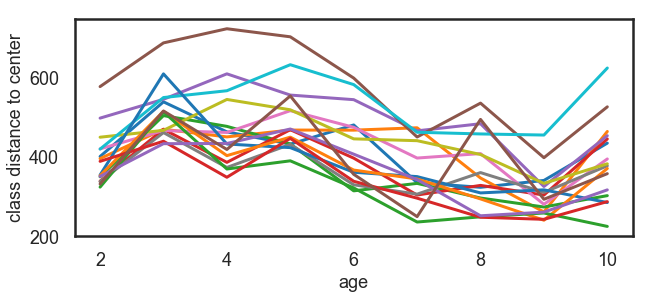

In [82]:
fig = plt.figure(figsize=(10,4))
plt.plot(age_list,class_distances)
plt.ylabel('class distance to center',fontsize = 18)
plt.xlabel('age', fontsize = 18)
plt.xticks(fontsize = 18); 
plt.yticks(fontsize = 18); 

plt.savefig('./plots/CategoryDispersionByAge_all_classes.png', bbox_inches="tight")

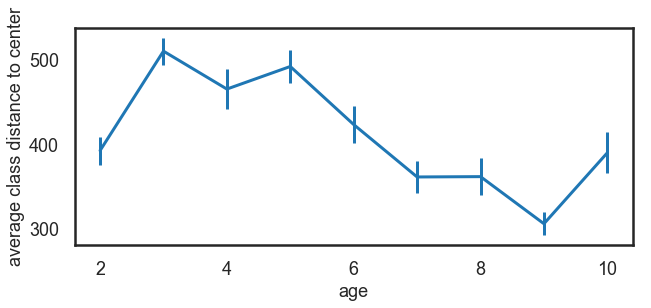

In [83]:
num_classes = 16
fig = plt.figure(figsize=(10,4))
plt.errorbar(age_list,np.mean(class_distances,1),yerr = np.std(class_distances,1)/np.sqrt(16))
plt.ylabel('average class distance to center',fontsize = 18)
plt.xlabel('age', fontsize = 18)
plt.xticks(fontsize = 18); 
plt.yticks(fontsize = 18); 

plt.savefig('./plots/CategoryDispersionByAge_errorbar_class_sem.png', bbox_inches="tight")

### How does the variability of the cosine distance to category center change with age?

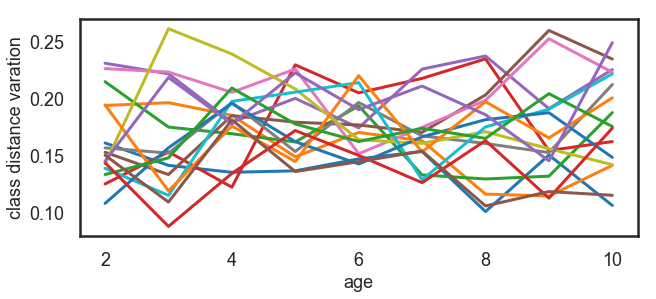

In [14]:
fig = plt.figure(figsize=(10,4))
plt.plot(age_list,class_distance_variation)
plt.ylabel('class distance varation',fontsize = 18)
plt.xlabel('age', fontsize = 18)
plt.xticks(fontsize = 18); 
plt.yticks(fontsize = 18); 

# plt.savefig('./plots/CategoryDispersionByAge_all_classes.png', bbox_inches="tight")

### Can do averages but large item effects - not sure if meaningful

In [15]:
# num_classes = 16
# fig = plt.figure(figsize=(10,4))
# plt.errorbar(age_list,np.mean(class_distance_variation,1),yerr = np.std(class_distance_variation,1)/num_classes)
# plt.ylabel('STD of distances to class center',fontsize = 18)
# plt.xlabel('age', fontsize = 18)
# plt.xticks(fontsize = 18); 
# plt.yticks(fontsize = 18); 

# plt.savefig('./plots/CategoryDispersionByAge_errorbar_class_sem.png', bbox_inches="tight")


# How do category centers shift across age?

In [16]:
## Calculate RDMS for each age and correlation with olderst 
rdm_by_age = np.zeros([9,120])
rdm_corr_by_age = np.zeros(9)

for age in range(10,1,-1):
    agei = age-2
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]

    class_means = get_class_means_bl(KF_subset, KM_subset, ordered_objs)
    this_rdm = distance.pdist(class_means,'cosine')
    
    if age==10:
        oldest_rdm = this_rdm
    else:
        rdm_by_age[agei,] = this_rdm
        out = stats.spearmanr(this_rdm,oldest_rdm)
        rdm_corr_by_age[agei] = out.correlation
        print 'RDM corr for age {} vs age 10 is {}'.format(age, rdm_corr_by_age[agei])

RDM corr for age 9 vs age 10 is 0.872081394541
RDM corr for age 8 vs age 10 is 0.854732967567
RDM corr for age 7 vs age 10 is 0.8525592055
RDM corr for age 6 vs age 10 is 0.917897076186
RDM corr for age 5 vs age 10 is 0.888207514411
RDM corr for age 4 vs age 10 is 0.764254462115
RDM corr for age 3 vs age 10 is 0.671296617821
RDM corr for age 2 vs age 10 is 0.588728383916


# How does class discriminability change with age?

In [17]:
def get_two_class_discrim(F,M,target_class,confusion_class):    
    target_class_features = F[M.label.values==target_class]
    target_class_mean = np.median(target_class_features, axis=0); # MEDIAN ovver rows, i.e. images
    num_target_images=np.shape(target_class_features)[0];
    
    conf_class_features = F[M.label.values==confusion_class]
    conf_class_mean = np.median(conf_class_features, axis=0); # MEDIAN ovver rows, i.e. images
    
    # open variables
    dist_target = np.zeros(num_target_images)   
    dist_conf = np.zeros(num_target_images) 
    discrim_target_conf = np.zeros(num_target_images)
    
    # for each image, get distance to category mean and to distractor mean
    for vi in range(num_target_images): 
        dist_target[vi] = distance.cosine(target_class_features[vi],target_class_mean) ## get euclidean distance to mean
        dist_conf[vi] = distance.cosine(target_class_features[vi],conf_class_mean) ## get euclidean distance to conf mean
        discrim_target_conf[vi]=dist_conf[vi]-dist_target[vi] ## subtract -- higher values: more discrim
    return np.mean(discrim_target_conf)

def show_confMatrix(confMatrix,ordered_objs,age):
    sns.set_context('paper')
    fig = plt.figure(figsize=(40,40))
#     plt.matshow(confMatrix, vmin=-2, vmax=10) # maximum pairwise value in data?
    plt.matshow(confMatrix) # maximum pairwise value in data?
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90,fontsize = 12);
    plt.yticks(range(len(ordered_objs)), ordered_objs,fontsize = 12); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False 
    plt.savefig('./plots/TwoClassDiscrim_{}_Layer_{}.pdf'.format(age, layer_ind), bbox_inches="tight")

0.0942036426414
0.084064529431
0.146120752048
0.201024181434
0.212917186881
0.245518255325
0.238059320925
0.247642353551
0.246708268543


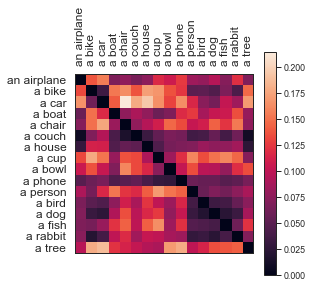

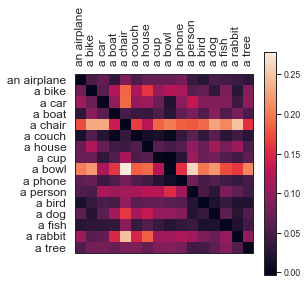

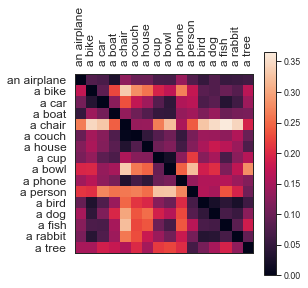

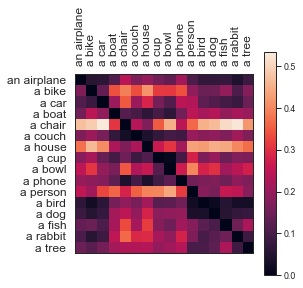

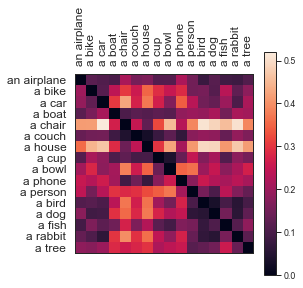

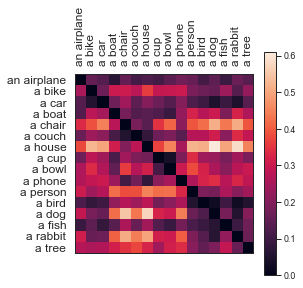

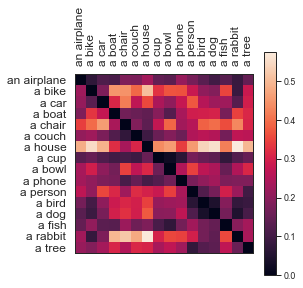

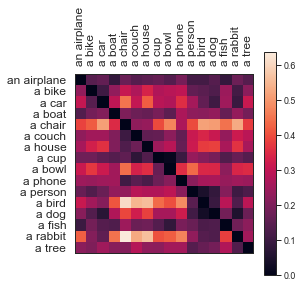

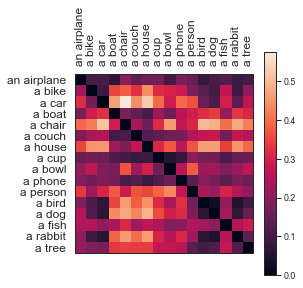

In [18]:
confMatrixbyAge = np.zeros([np.shape(ordered_objs)[0],np.shape(ordered_objs)[0],9])
for age in (2,3,4,5,6,7,8,9,10):
    agei=age-2
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    
    
    confMatrix = np.zeros([np.shape(ordered_objs)[0],np.shape(ordered_objs)[0]])
    for t, target_label in enumerate(ordered_objs):
        for c, conf_label in enumerate(ordered_objs):
            confMatrix[t,c]=get_two_class_discrim(KF_subset,KM_subset,target_label,conf_label)  
    
    print np.mean(confMatrix[np.where(~np.eye(confMatrix.shape[0],dtype=bool))])
    confMatrixbyAge[:,:,agei]=confMatrix
    show_confMatrix(confMatrix,ordered_objs,age)


### Look at multi-class MDS for each age using tSNE for dimensionality reduction -- eh, not convinced this is useful

In [19]:
## Import libaries
from sklearn.metrics import pairwise
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
seed = np.random.RandomState(seed=3)
from sklearn import manifold
from sklearn.manifold import TSNE

# https://distill.pub/2016/misread-tsne/ -- good resource


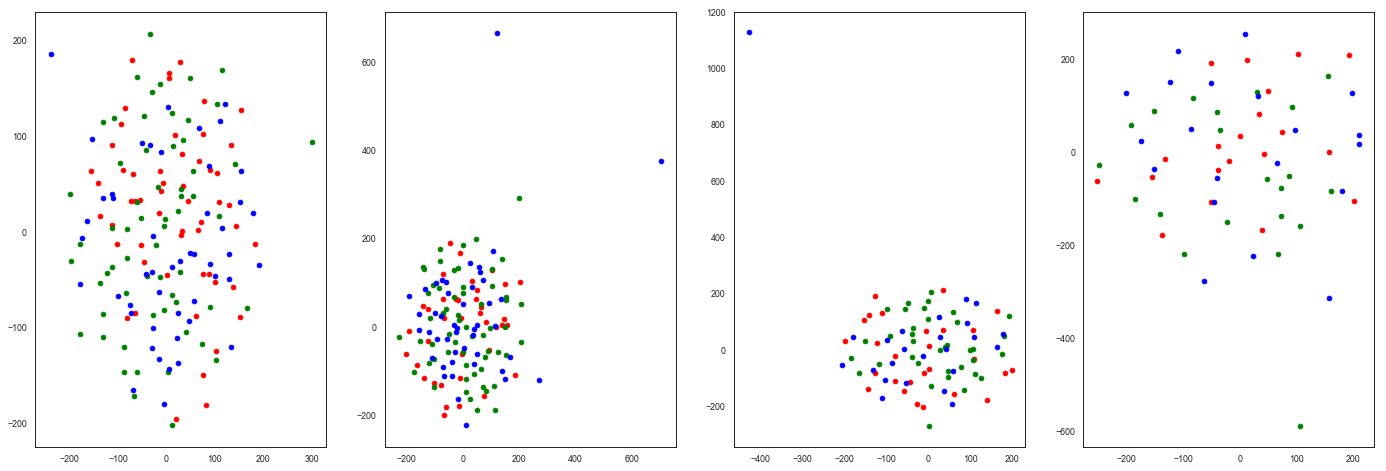

In [20]:
n_samples = 100 # roughly minimum we might have with two classes
n_components = 3
perplexity = 25 ## arbitrary value -- "(loosely) how to balance attention between local and global aspects of your data. 

# Cluster sizes in a t-SNE plot mean nothing
# The basic message is that distances between well-separated clusters in a t-SNE plot may mean nothing.

first_class='a fish'
second_class='a bird'
third_class='a dog'

age_test = [3,5,7,9]
(fig, subplots) = plt.subplots(1,len(age_test), figsize=(24, 8))
for agei, age in enumerate(age_test):
    ## Subset to the age and classes of interest
    ind = KM.index[KM['age'] == age] & (KM.index[KM.label.values==first_class] | KM.index[KM.label.values==second_class] | KM.index[KM.label.values==third_class])
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    KM_subset = KM_subset.reset_index(drop=True)

    
    first_class_ind = [KM_subset['label']==first_class][0]
    second_class_ind = [KM_subset['label']==second_class][0]
    third_class_ind = [KM_subset['label']==third_class][0]

    tsne = manifold.TSNE(n_components=n_components, init='random',
                             random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(KF_subset)
    ax = subplots[agei]
    
    
    ax.scatter(Y[first_class_ind, 0], Y[first_class_ind, 1], c='r')
    ax.scatter(Y[second_class_ind, 0], Y[second_class_ind, 1], c='g')
    ax.scatter(Y[third_class_ind, 0], Y[third_class_ind, 1], c='b')


In [21]:
# first_class='a person'
# second_class='a cup'
# third_class='a house'
# fig, axs = plt.subplots(3, 3, figsize=(9, 9), sharey=True, sharex=True)

# for agei, age in enumerate(range(2,11)):
#     ## Subset to the age and classes of interest
#     ind = KM.index[KM['age'] == age] & (KM.index[KM.label.values==first_class] | KM.index[KM.label.values==second_class] | KM.index[KM.label.values==third_class])
#     KM_subset =  KM.loc[ind]
#     KF_subset =  KF[ind.tolist()]
    
#     plotColors = np.zeros([np.size(KM_subset.label),3])
#     for i,v in enumerate(np.asarray(KM_subset.label)):
#         if v==first_class:
#             plotColors[i]=[255,0,0]
#         elif v==second_class:
#             plotColors[i]=[0,0,255]
#         elif v==third_class:
#             plotColors[i]=[0,255,0]
    
#     ## Compute distances on this subset
#     subset_distances = pairwise.euclidean_distances(KF_subset)
#     mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
#                        dissimilarity="precomputed", n_jobs=1)
#     pos = mds.fit(subset_distances).embedding_
#     s = 10 ## size of the dots
#     ## sublot indexes, messy but OK for now
#     if agei<3: ## 0,1,2
#         plot_row=0
#         plot_col=agei
#     elif (agei>2) and (agei<6):
#         plot_row=1
#         plot_col=agei-3  
#     elif agei>5: # 6,7,8
#         plot_row=2
#         plot_col=agei-6
#     else:
#         error('badly specified plots')
    
#     axs[plot_row,plot_col].scatter(pos[:, 0], pos[:, 1], c=plotColors/255.0, s=s, lw=0, label='MDS')
# #     axs[agei].title('age' + str(age) + " " + first_class + " vs. "+ second_class)
#     axs[plot_row,plot_col].set_xlim([-200,200])
#     axs[plot_row,plot_col].set_ylim([-200,200])
#     axs[plot_row,plot_col].set_title('age' + str(age))
    
# plt.savefig('./plots-MDS/Distance_MDS_{}_{}_{}.pdf'.format(first_class,second_class,third_class), bbox_inches="tight")
